## **Import required libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import time

## **Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True, timeout_ms=120000*5)

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/Speech_Project/train_16k_normalised_zeroPadded.zip' -d '/content/Train'
!unzip -q '/content/drive/My Drive/Speech_Project/test_16k_normalised_zeroPadded.zip' -d '/content/Test'

In [ ]:
class my_Dataset(Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, data_paths, target_paths, transform=None):
        self.data_paths = data_paths
        self.target_paths = target_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index):
        x = torch.from_numpy(np.expand_dims(np.load(self.data_paths[index]),axis = 0))
        y = torch.from_numpy(np.expand_dims(np.load(self.target_paths[index]),axis = 0))
        if self.transform:
            x = self.transform(x)

        return x, y

root_train_input = '/content/Train/train_16k_normalised_zeroPadded/train_input/'
root_train_output = '/content/Train/train_16k_normalised_zeroPadded/train_output/' 
root_test_input = '/content/Test/test_16k_normalised_zeroPadded/test_input/'
root_test_output = '/content/Test/test_16k_normalised_zeroPadded/test_output/' 

train_input = sorted(os.listdir(root_train_input))
train_output = sorted(os.listdir(root_train_output))
test_input = sorted(os.listdir(root_test_input))
test_output = sorted(os.listdir(root_test_output))

train_input = list(map(root_train_input.__add__,train_input))
train_output = list(map(root_train_output.__add__,train_output))
test_input = list(map(root_test_input.__add__,test_input))
test_output = list(map(root_test_output.__add__,test_output))
print(len(train_output), len(train_input), len(test_output), len(test_input))

train_set = my_Dataset(train_input,train_output) 
test_dataset = my_Dataset(test_input,test_output)       

40332 40332 3635 3635


In [ ]:
generator=torch.Generator().manual_seed(123)
train_dataset, val_dataset = torch.utils.data.random_split(train_set, [round(train_set.__len__()*0.95),round(train_set.__len__()*0.05)],generator=generator)

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=200)
val_loader = DataLoader(val_dataset,batch_size=200)

## **Data visualisation**

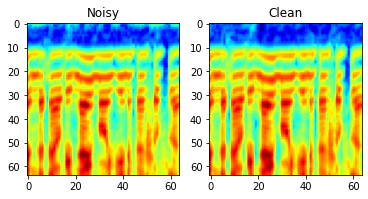

In [ ]:
a,b = next(iter(train_loader))
fig, axs = plt.subplots(1,2)
axs[0].imshow(a[2][0], cmap='jet')
axs[0].set_title('Noisy')
axs[1].imshow(b[2][0], cmap='jet')
axs[1].set_title('Clean')
plt.show()

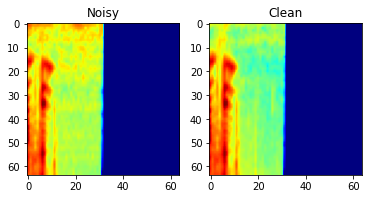

In [ ]:
a,b = next(iter(val_loader))
fig, axs = plt.subplots(1,2)
axs[0].imshow(a[0][0], cmap='jet')
axs[0].set_title('Noisy')
axs[1].imshow(b[0][0], cmap='jet')
axs[1].set_title('Clean')
plt.show()

### Exploration of mask values

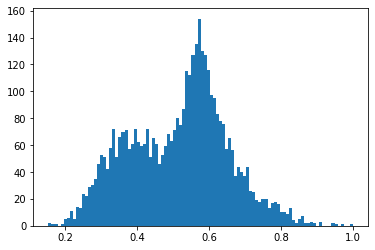

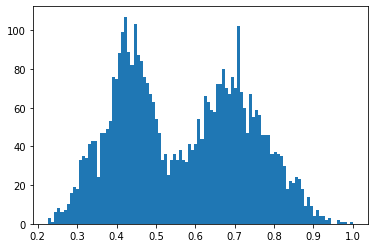

In [ ]:
i = 5

plt.hist(a[i][0].ravel(),bins = 100)
plt.show()

plt.hist(b[i][0].ravel(),bins = 100)
plt.show()

## **Architecture: CNN Model**

In [ ]:
class CNN_TF(nn.Module):

    def __init__(self, kernel_size=4, stride=2, filter_size_1=64, filter_size_2=128, filter_size_3=256, filter_size_4=512, bottle_neck_size=100):
        super(CNN_TF, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.filter_size_1 = filter_size_1
        self.filter_size_2 = filter_size_2
        self.filter_size_3 = filter_size_3
        self.filter_size_4 = filter_size_4
        self.bottle_neck_size = bottle_neck_size

        self.conv2d_1 = nn.Conv2d(1, filter_size_1, kernel_size, stride)
        self.conv2d_2 = nn.Conv2d(filter_size_1, filter_size_2, kernel_size, stride)
        self.conv2d_3 = nn.Conv2d(filter_size_2, filter_size_3, kernel_size, stride)
        self.conv2d_4 = nn.Conv2d(filter_size_3, filter_size_4, kernel_size, stride)

        self.flatten = nn.Flatten()
        self.bottle_neck = nn.Linear(filter_size_4*2*2, bottle_neck_size)
        self.bn_to_deconv = nn.Linear(bottle_neck_size, filter_size_4*2*2)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

        self.batchnorm_encoder1 = nn.BatchNorm2d(filter_size_1)
        self.batchnorm_encoder2 = nn.BatchNorm2d(filter_size_2)
        self.batchnorm_encoder3 = nn.BatchNorm2d(filter_size_3)
        self.batchnorm_encoder4 = nn.BatchNorm2d(filter_size_4)

        self.batchnorm_decoder4 = nn.BatchNorm2d(filter_size_3)
        self.batchnorm_decoder3 = nn.BatchNorm2d(filter_size_2)
        self.batchnorm_decoder2 = nn.BatchNorm2d(filter_size_1)
        self.batchnorm_decoder1 = nn.BatchNorm2d(1)

        self.deconv2d_4 = nn.ConvTranspose2d(filter_size_4, filter_size_3, kernel_size, stride)
        self.deconv2d_3 = nn.ConvTranspose2d(filter_size_3, filter_size_2, kernel_size, stride)
        self.deconv2d_2 = nn.ConvTranspose2d(filter_size_2, filter_size_1, kernel_size, stride, output_padding=1)
        self.deconv2d_1 = nn.ConvTranspose2d(filter_size_1, 1, kernel_size, stride)


    def forward(self, spectrogram):

        x = self.conv2d_1(spectrogram)
        x = self.batchnorm_encoder1(x)
        x = self.relu(x)

        x = self.conv2d_2(x)
        x = self.batchnorm_encoder2(x)
        x = self.relu(x)

        x = self.conv2d_3(x)
        x = self.batchnorm_encoder3(x)
        x = self.relu(x)

        x = self.conv2d_4(x)
        x = self.batchnorm_encoder4(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.bottle_neck(x)
        x = self.bn_to_deconv(x)
        x = torch.reshape(x, (-1,512,2,2))

        x = self.deconv2d_4(x)
        x = self.batchnorm_decoder4(x)
        x = self.relu(x)

        x = self.deconv2d_3(x)
        x = self.batchnorm_decoder3(x)
        x = self.relu(x)

        x = self.deconv2d_2(x)
        x = self.batchnorm_decoder2(x)
        x = self.relu(x)

        x = self.deconv2d_1(x)

        x = self.batchnorm_decoder1(x)
        #x = self.sigmoid(x)
        x = spectrogram * x

        return x

In [ ]:
from torchsummary import summary
summary(CNN_TF().cuda(),(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]           1,088
       BatchNorm2d-2           [-1, 64, 31, 31]             128
         LeakyReLU-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 128, 14, 14]         131,200
       BatchNorm2d-5          [-1, 128, 14, 14]             256
         LeakyReLU-6          [-1, 128, 14, 14]               0
            Conv2d-7            [-1, 256, 6, 6]         524,544
       BatchNorm2d-8            [-1, 256, 6, 6]             512
         LeakyReLU-9            [-1, 256, 6, 6]               0
           Conv2d-10            [-1, 512, 2, 2]       2,097,664
      BatchNorm2d-11            [-1, 512, 2, 2]           1,024
        LeakyReLU-12            [-1, 512, 2, 2]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                  [

## **Training loop**

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
# shape = (n, 1, 64, 64)
#def train_cnn(train_loader,val_loader, n_epochs=20, batch_size=200, lr=0.0002, load_path = None):
n_epochs = 35
batch_size=200
lr=0.002
load_path = None

cnn_tf = CNN_TF().cuda()
cnn_tf.double()
if load_path: 
      state_dict = torch.load(load_path)
      cnn_tf.load_state_dict(state_dict['model'].state_dict())
      #opt = state_dict['optimizer']
    
opt = optim.Adam(cnn_tf.parameters(), lr=lr)
params = cnn_tf.parameters()
print('params calculated')

    
criterion = nn.MSELoss()  
total_loss = 0
val_loss = 0
best_val_loss = 1e10

running_loss = {'train': [], 'val': []}
print('loaded loss and opt')

for i in range(n_epochs):
    
        epoch_loss = 0
        val_loss = 0
        start = time.time()
        for j, (batch_input,batch_output) in enumerate(train_loader):
            opt.zero_grad()
            # print(batch_input.shape, batch_output.shape)
            model_output = cnn_tf(batch_input.cuda())
  
            # print(model_output.shape)
            loss = criterion(model_output, batch_output.cuda())

            loss.backward()
            opt.step()

            epoch_loss+=loss.item()
            del batch_input, batch_output

        print('\n\n Epoch ',i+1 ,' : Train Loss = ', epoch_loss/len(train_loader), '  time taken = ', time.time()-start,'s')
        running_loss['train'].append(epoch_loss/len(train_loader))

        for val_input, val_output in val_loader:
          model_output = cnn_tf(val_input.cuda())
          valloss = criterion(model_output, val_output.cuda())
          val_loss += valloss.item()
          del valloss, model_output
        
        val_loss = val_loss/len(val_loader)

        print('             Val Loss = ', val_loss) 
        running_loss['val'].append(val_loss)
        
        # Save model state after each epoch
        state = {'model': cnn_tf,
                'optimizer': opt}

        filename = '/content/drive/My Drive/Speech_Project/explicit_cnn/norm_zeroPadded_noAct.pth.tar'
        if val_loss <= best_val_loss:
          torch.save(state, filename)
          best_val_loss = val_loss
          print("Best Loss: %.5f",best_val_loss)
          print('             Checkpointed model state')
        torch.cuda.empty_cache()

params calculated
loaded loss and opt


 Epoch  1  : Train Loss =  0.31807634079090813   time taken =  275.1246008872986 s
             Val Loss =  0.2390852152821618
Best Loss: %.5f 0.2390852152821618
             Checkpointed model state


 Epoch  2  : Train Loss =  0.22635727991654075   time taken =  264.54877042770386 s
             Val Loss =  0.21533683582489413
Best Loss: %.5f 0.21533683582489413
             Checkpointed model state


 Epoch  3  : Train Loss =  0.21212207027611465   time taken =  255.3708701133728 s
             Val Loss =  0.20522042098565524
Best Loss: %.5f 0.20522042098565524
             Checkpointed model state


 Epoch  4  : Train Loss =  0.20438374554806005   time taken =  255.6779351234436 s
             Val Loss =  0.20051043644821506
Best Loss: %.5f 0.20051043644821506
             Checkpointed model state


 Epoch  5  : Train Loss =  0.19869048814539605   time taken =  255.39353132247925 s
             Val Loss =  0.19647014459674958
Best Loss: %.5f 

### **Loss curves**

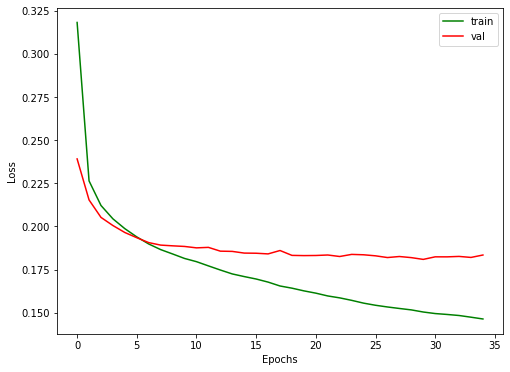

In [ ]:
num_epochs = range(0,len(running_loss['train']))

plt.figure(figsize = (8,6))
plt.plot(num_epochs, running_loss['train'],'g')
plt.plot(num_epochs, running_loss['val'],'r')
plt.legend(['train','val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('/content/drive/My Drive/Speech_Project/explicit_cnn/norm_zeroPadded_noAct.jpg')
plt.show()


## **Evaluation on test data**

In [ ]:
test_loader = DataLoader(test_dataset,batch_size=200)

In [ ]:
criterion  = nn.MSELoss()
loss = 0
for batch_input, batch_output in test_loader:
    loss += criterion(batch_input,batch_output).item()

In [ ]:
print('Testset loss = ', loss/len(test_loader))

Testset loss =  0.008428970991176206


In [ ]:
model = CNN_TF().cuda()
model = model.double()
load_path = '/content/drive/My Drive/Speech_Project/models/model_cnn.pth.tar'
state_dict = torch.load(load_path)
model.load_state_dict(state_dict['model'].state_dict())

loss = 0
predicted = []
for j, (batch_input,batch_output) in enumerate(test_loader):
    model_output = model(batch_input.cuda())
    loss += criterion(model_output,batch_output.cuda()).item()
    predicted.append(model_output.detach().cpu().numpy())
print('Model output testset loss = ', loss/len(test_loader))

Model output testset loss =  2.0653301781870668


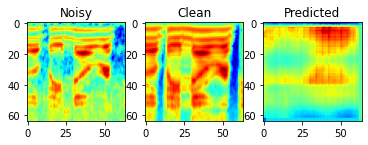

In [ ]:
a,b = next(iter(test_loader))
c = model(a.cuda()).detach().cpu()
fig, axs = plt.subplots(1,3)
axs[0].imshow(a[1][0], cmap='jet')
axs[0].set_title('Noisy')
axs[1].imshow(b[1][0], cmap='jet')
axs[1].set_title('Clean')
axs[2].imshow(c[1][0], cmap='jet')
axs[2].set_title('Predicted')
plt.show()

## **Save Predicted GTgrams**

In [ ]:
from scipy.io import savemat, loadmat
import shutil

In [ ]:
shutil.rmtree('/content/predicted/')

In [5]:
root = '/content/Test/test_16k_normalised_zeroPadded/test_input/'
os.mkdir('/content/predicted/')
save_root = '/content/predicted/'
test_files = os.listdir(root)
audios = []
for name in test_files:
    audio = '_'.join(name.split('_')[:3])
    if audio not in audios:
      audios.append(audio)

In [ ]:
for i,name in enumerate(audios):
    input_files = sorted(list(filter(lambda x: x.startswith(name + "_") , test_files)))
    positions = np.argsort([int(x.split('.')[0].split('_')[-1])-1 for x in input_files])
    #ordered_files = input_files[positions]

    input_arr = []
    for filename in input_files:
    x = np.expand_dims(np.load(root+filename),axis = 0)
    input_arr.append(x)
    model_input = torch.from_numpy(np.array(input_arr))
    model_output = model(model_input.cuda()).detach().cpu().numpy()

    arranged_out = model_output[positions]
    concat_out = np.concatenate((arranged_out), axis = 2)

    savemat( save_root+name+'.mat', mdict = {'PRED_SPEC': concat_out[0]})

In [ ]:
!zip -q -r stand_zeroPadded_noAct_test.zip 'predicted'

In [ ]:
!cp '/content/stand_zeroPadded_noAct_test.zip' '/content/drive/My Drive/Speech_Project/explicit_cnn/'